Element Linear Regression

In [48]:
import os
import glob
import numpy as np

from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
%matplotlib inline

Things to input first hand

number of nodes in each layer
activation function used


In [60]:
NOFNODES = 20

NOFATOMS = {'H': 128, 'O': 64} #as a dict
NOFATOMS_TEST = {'H': 128, 'O': 64} #as a dict

conv_energy = 7.8389970542204770        #check this value before implementing
mean_energy = -5.7452783952905939

el = [1, 8]

In [61]:
print(os.getcwd())
home = '/Users/shubhamdongriyal/my-drive/SabIA/HDNNP/H2O-Bing/MulRegression'

/Users/shubhamdongriyal/my-drive/SabIA/HDNNP/H2O-Bing/MulRegression/seed-9812345/trainset/data-16


In [62]:
#dictionary of elements

id2el = {1: 'H', 6: 'C', 7: 'N', 8: 'O', 9: 'F', 15: 'P', 16: 'S', 17: 'Cl', 35: 'Br', 53: 'I'}
el2id = {v: k for k, v in id2el.items()}

In [63]:
def symmetryfunction(FUNCTION, SCALING):
    # func_data = np.loadtxt(FUNCTION, usecols= range(0, NOOFSYM + 1)) # change 43 to dynamic number of columns
    # print(f' Shape of Symmetry functions: (number of atoms * number of frames) x (number of symmetry function + 1) \n {func_data.shape}')
    
    # el = list(set(func_data[:, 0])) # list of unique elements
    # print(f' Number of unique elements: {len(el)}')

    # print(f'1st element: {el[0]} --- {id2el[el[0]]}')
    # print(f'2nd element: {el[1]} --- {id2el[el[1]]}')

    # sf = {id2el[i]: func_data[np.any(func_data== i, axis = 1)][:, 1:43] for i in el}   #give symmetry function of each element

    with open(FUNCTION) as f:
        lines = f.readlines()
        data = [line.split() for line in lines] #data is in memory now

    el = np.asarray(sorted(list({x[0] for x in data})), dtype = int)

    print(f' Number of unique elements: {len(el)} \n 1st element: {el[0]} --- {id2el[el[0]]} \n 2nd element: {el[1]} --- {id2el[el[1]]}')

    l1, l2 = [], []
    for i in data:
        if i[0] == str(el[0]):
            l1.append(i)
        if i[0] == str(el[1]):
            l2.append(i)

    l1 = np.asarray(l1, dtype = float)
    l2 = np.asarray(l2, dtype = float)

    NOFSYM = [l1.shape[1] - 1, l2.shape[1] - 1]
    print(f'Number of symmetry functions:\n for el:1 {NOFSYM[0]} \n for el:2 {NOFSYM[1]}')

    sf = {id2el[el[0]]: l1[:, 1:NOFSYM[0] + 1], id2el[el[1]]: l2[:, 1:NOFSYM[1] + 1]}
    #code from here

    # Scaling of symmetry functions
    scale = np.loadtxt(SCALING, usecols= (2, 3, 4, 5))

    scalingmat = {id2el[el[0]]: scale[0:NOFSYM[0], :].T, id2el[el[1]]: scale[NOFSYM[0]:, :].T} #only for 2 elements have to generalize for more elements
    #print(scalingmat)

    #scaled symmetry functions
    scaledsf = {id2el[i]: ((sf[id2el[i]] - scalingmat[id2el[i]][2]) / (scalingmat[id2el[i]][1] - scalingmat[id2el[i]][0])) for i in el}

    return scaledsf, el, NOFSYM



In [64]:
# scaledsf, el, NOFSYM = symmetryfunction(FUNCTION= os.path.join(home, 'trainset/data-1/function.cleaned.data'), SCALING= os.path.join(home, 'trainset/data-1/scaling.data'))

In [65]:
# scaledsf['O'].shape

In [66]:
def weightmat(wlist, el, NOFSYM):
    
    weights = {}
    for i, nofsym, wlist in zip(el, NOFSYM, wlist):
        w = np.loadtxt(wlist, usecols = 0)

        w0 = w[:nofsym * NOFNODES].reshape(nofsym, NOFNODES) #can be much more generalized
        b0 = w[nofsym * NOFNODES:(nofsym * NOFNODES) + NOFNODES]
        w1 = w[(nofsym * NOFNODES) + NOFNODES: (nofsym * NOFNODES) + NOFNODES + (NOFNODES * NOFNODES)].reshape(NOFNODES, NOFNODES)
        b1 = w[(nofsym * NOFNODES) + NOFNODES + (NOFNODES * NOFNODES) : (nofsym * NOFNODES) + 2 * NOFNODES + (NOFNODES * NOFNODES)]
        w2 = w[(nofsym * NOFNODES) + 2 * NOFNODES + (NOFNODES * NOFNODES) : (nofsym * NOFNODES) + 2 * NOFNODES + (NOFNODES * NOFNODES) + NOFNODES]
        b2 = w[(nofsym * NOFNODES) + 2 * NOFNODES + (NOFNODES * NOFNODES) + NOFNODES : (nofsym * NOFNODES) + 2 * NOFNODES + (NOFNODES * NOFNODES) + NOFNODES + 1]

        weights[id2el[i]] = [w0, b0, w1, b1, w2, b2]

    return weights

In [67]:
#activation functions

def activation(x, act):
    if act == 'sigmoid':
        return 1 / (1 + np.exp(-x))
    elif act == 'softplus':
        return np.log(1 + np.exp(x))
    elif act == 'ReLU':
        return np.maximum(0, x)
    elif act == 'tanh':
        return np.tanh(x)
    else:
        print('Invalid activation function')
        return None

# def sigmoid(x): return 1 / (1 + np.exp(-x))

# def softplus(x): return np.log(1 + np.exp(x))

# def ReLU(x): return np.maximum(0, x)

# def tanh(x): return np.tanh(x)

In [68]:
def forwardpass(scaledsf, weightmat, el):
    
    #same create dictionary for the elements
    featuresll = {}
    energycontri = {}
    
    for i in el:
        ll = []
        ec = []
        for j in range(scaledsf[id2el[i]].shape[0]):
            w0 = weightmat[id2el[i]][0]
            b0 = weightmat[id2el[i]][1]
            w1 = weightmat[id2el[i]][2]
            b1 = weightmat[id2el[i]][3]
            w2 = weightmat[id2el[i]][4]
            b2 = weightmat[id2el[i]][5]

            y1 = (w0.T @ scaledsf[id2el[i]][j]) + b0
            y1 = activation(y1, 'tanh')

            y2 = (w1.T @ y1) + b1
            y2 = activation(y2, 'tanh')

            ll.append(y2)
            y3 = (w2.T @ y2) + b2

            ec.append(y3)
        featuresll[id2el[i]] = np.array(ll).reshape(-1, NOFNODES)   # reshaping over here to make it compatible with the energy contribution
        energycontri[id2el[i]] = np.array(ec).reshape(-1, 1)

    return featuresll, energycontri

In [69]:
def feature_extractor(FUNCTION, SCALING):
    scaledsf, el, NOFSYM = symmetryfunction(FUNCTION, SCALING)
    weights = weightmat(wlist = sorted(glob.glob(os.path.join(home, 'seed-9812345/weight*'))), el = el, NOFSYM = NOFSYM)
    featuresll, energycontri = forwardpass(scaledsf = scaledsf, weightmat = weights, el = el)

    return featuresll, energycontri

In [70]:
#featurell, energycontri = feature_extractor(FUNCTION= os.path.join(home, 'trainset/data-1/function.cleaned.data'), SCALING= os.path.join(home, 'trainset/data-1/scaling.data'))

In [71]:
# print(featurell['O'].shape)
# print(energycontri['O'].shape)

I have to use train function multiple time to create a dictionary of models on which i can perform Linear Regressions.

model1 = [features , energy contri]
model2 = [...]
:
:   

In [72]:
datasets = sorted(glob.glob(os.path.join(home, 'seed-9812345/trainset/data-*')), key= lambda x: int(x.split('-')[-1]))

def committee():
    committee_model = {}
    for model, dataset in enumerate(datasets):
        os.chdir(dataset)
        (features, energy_contribution) = feature_extractor(FUNCTION = 'function.cleaned.data', SCALING = 'scaling.data')

        committee_model['model-' + str(model)] = (features, energy_contribution)
    
    return committee_model
    

In [73]:
committee_model = committee()

 Number of unique elements: 2 
 1st element: 1 --- H 
 2nd element: 8 --- O
Number of symmetry functions:
 for el:1 27 
 for el:2 30
 Number of unique elements: 2 
 1st element: 1 --- H 
 2nd element: 8 --- O
Number of symmetry functions:
 for el:1 27 
 for el:2 30
 Number of unique elements: 2 
 1st element: 1 --- H 
 2nd element: 8 --- O
Number of symmetry functions:
 for el:1 27 
 for el:2 30
 Number of unique elements: 2 
 1st element: 1 --- H 
 2nd element: 8 --- O
Number of symmetry functions:
 for el:1 27 
 for el:2 30
 Number of unique elements: 2 
 1st element: 1 --- H 
 2nd element: 8 --- O
Number of symmetry functions:
 for el:1 27 
 for el:2 30
 Number of unique elements: 2 
 1st element: 1 --- H 
 2nd element: 8 --- O
Number of symmetry functions:
 for el:1 27 
 for el:2 30
 Number of unique elements: 2 
 1st element: 1 --- H 
 2nd element: 8 --- O
Number of symmetry functions:
 for el:1 27 
 for el:2 30
 Number of unique elements: 2 
 1st element: 1 --- H 
 2nd element: 8

In [74]:
committee_model['model-1'][1]['H']

array([[-0.29781982],
       [-0.21944437],
       [-0.29785538],
       ...,
       [-0.50797366],
       [-0.68549651],
       [-0.3933264 ]])

In [75]:
# committee_model['model-2'][0]['H']

In [76]:
# committee_model['model-0'][0]['C'].reshape(-1, 80, 25).shape # [0] for features, [1] for energy contribution


In [77]:
# #plotting the feature vs atomic contribution for H1 for different models

# # fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(15, 12))
# # plt.subplots_adjust(hspace=0.5)

# plt.figure( figsize= (15, 12))
# plt.subplots_adjust(hspace=0.5)
# for key, values in committee_model.items():
#     x = values[0]['H']
#     y = values[1]['H']

#     ax = plt.subplot(4, 4, int(key.split('-')[-1]) + 1)
#     ax.scatter(x[:, 0, :], y[:, 0, 0])


In [78]:
def linear_regression(committee_model, el):
    lr_models = {}
    for key, values in enumerate(committee_model.values()):
        lr ={}
        for j in el:
            x = values[0][id2el[j]]
            y = values[1][id2el[j]]

            #print(x.shape, y.shape)

            lr[id2el[j]] = LinearRegression(fit_intercept= False).fit(x, y) #dic for LR for 1 model
        lr_models['model-' + str(key)] = lr
        
    return lr_models
#un-scaling should be done only at prediction


In [79]:
lr_models = linear_regression(committee_model, el = el)

Weights are same for all the models in linear regression model.

But if the turn off the intercept then values are differing.

In [80]:
# print(lr_models['model-0']['H'].coef_ == lr_models['model-10']['H'].intercept_)
# print(lr_models['model-0']['H'].intercept_)
print(lr_models['model-10']['H'].coef_)
print(lr_models['model-1']['H'].coef_)
# print(lr_models['model-10']['H'].intercept_)

# print(lr_models['model-0']['H'].coef_ - lr_models['model-10']['H'].coef_)

[[-2.24950085  1.42411733 -0.10274681  0.96233882 -0.10406463  0.52914312
  -1.14180303 -0.79890749 -0.88974109  0.31532582  0.25282111 -1.45834193
   1.34558671  0.02481693  0.40165698 -0.8153224  -0.30125602 -1.25134725
   0.87925055  0.38251635]]
[[-2.29377084  1.47121153 -0.13931305  0.99402831 -0.07978475  0.60441376
  -1.1293293  -0.81590917 -0.96376542  0.32660075  0.22455634 -1.51039998
   1.37387741  0.04010482  0.42915846 -0.91362239 -0.32575194 -1.28467563
   0.89104543  0.3824868 ]]


In [81]:
#test set selection and prediction
feature_test, energy_test = feature_extractor(FUNCTION = os.path.join(home, 'testset/test-validationset/seed-9812345/nnp-train/function.cleaned.data'), SCALING = os.path.join(home, 'testset/test-validationset/seed-9812345/nnp-train/scaling.data'))
NOFFRAMES_TEST = 161

 Number of unique elements: 2 
 1st element: 1 --- H 
 2nd element: 8 --- O
Number of symmetry functions:
 for el:1 27 
 for el:2 30


In [82]:
print(feature_test['O'].shape)

(10304, 20)


In [83]:
# #prediction for single frame
# def prediction(lr_models, feature_test, energy_test, el):

#     atomic_contri = {}
#     total_energy = {}
#     for key, values in enumerate(lr_models.values()):
#         lr_pred = {}
#         el_en = []
#         for j in el:
#             x = feature_test[id2el[j]]
#             y = energy_test[id2el[j]].reshape(NOFATOMS[id2el[j]],1)
            
#             lr_pred[id2el[j]] = [ (y[k] / conv_energy, values[id2el[j]][k].predict(x[:, k, :]) / conv_energy) for k in range(NOFATOMS[id2el[j]])] #dic of list of tuples containing UNSCALED (true_y, y_pred) 
            
#             el_en.append(np.sum([en[1] + mean_energy for en in lr_pred[id2el[j]]]))

#         atomic_contri['model-' + str(key)] = lr_pred
#         total_energy['model-' + str(key)] = np.sum(el_en)

#     return atomic_contri, total_energy


In [84]:
# #single prediction
# atomic_contri, total_energy = prediction(lr_models, feature_test, energy_test, el)  #correct

# committee_mean = np.mean(list(total_energy.values()))
# committee_std = np.std(list(total_energy.values()))

# print(f'Total Number of Committee NNs: {len(total_energy)}')
# print(f'Committee Mean Energy: {committee_mean} eV\nCommittee Standard Deviation: {committee_std} eV')

In [85]:
#prediction for multiple frames
def multi_frame_prediction(lr_models, feature_test, energy_test, el):
    total_energy = {}
    for key, values in enumerate(lr_models.values()):  #model loop
        energies = []
        for k in range(NOFFRAMES_TEST): #frame loop
            frame_energy = []
            for j in el:    #element loop
                #frame_energy_el = 0
                x = feature_test[id2el[j]].reshape(-1, NOFATOMS_TEST[id2el[j]], 20)[k]
                
                #y = energy_test[id2el[j]][k].reshape(NOFATOMS[id2el[j]],1) #no need for prediction anyway

                kframe_encontri_el = [(values[id2el[j]].predict(x[z, :].reshape(1, -1)) / conv_energy) for z in range(NOFATOMS_TEST[id2el[j]])] #atom loop
                frame_energy_el = np.sum([encon + mean_energy for encon in kframe_encontri_el])

                frame_energy.append(frame_energy_el)
            #print(len(frame_energy))
            total_frame_one_energy = np.sum(frame_energy)
            energies.append(total_frame_one_energy)

        total_energy['model-' + str(key)] = energies
    return total_energy

                    

In [87]:
#multiple prediction at once
total_energy = multi_frame_prediction(lr_models, feature_test, energy_test, el = el)
en_mat =  np.asarray([i for i in total_energy.values()])
mean_energy_per_frame = np.mean(en_mat, axis = 0)
std_energy_per_frame = np.std(en_mat, axis = 0)

ANALYSIS

In [88]:
#true energy
true_energy = np.loadtxt(os.path.join(home, 'testset/test-validationset/seed-9812345/energy.out'))

In [89]:
n2p2_energy = np.loadtxt(os.path.join(home, 'testset/test-validationset/seed-9812345/n2p2_energy_frames.out'), usecols= (0))


In [96]:
print(f'True energies: \n{true_energy[:10]}\n\nCommittee energies: \n{mean_energy_per_frame[:10]}\n\nn2p2 energies: \n{n2p2_energy[:10]}\n\nStandard Deviation: \n{std_energy_per_frame[:10]}\n\ndiff btw committee and n2p2: \n{mean_energy_per_frame[:10] - n2p2_energy[:10]}\n\nStandard Deviation sorted des(just to see highest std) : \n{-np.sort(-std_energy_per_frame)[:10]}')

True energies: 
[-1103.17346 -1102.16858 -1103.28502 -1103.38608 -1103.02741 -1103.00416
 -1102.26983 -1103.54368 -1103.3913  -1102.11597]

Committee energies: 
[-1103.1526499  -1102.61954877 -1102.98953    -1103.04829368
 -1102.72314913 -1103.26998668 -1103.18313893 -1103.20777639
 -1103.06583484 -1102.14046722]

n2p2 energies: 
[-1103.1685  -1102.19683 -1103.29376 -1103.38402 -1103.0317  -1102.99624
 -1102.37373 -1103.54925 -1103.38979 -1102.10745]

Standard Deviation: 
[0.04147185 0.08894134 0.02046591 0.03291304 0.13925323 0.27472563
 0.11026056 0.02627197 0.02162176 0.16065792]

diff btw committee and n2p2: 
[ 0.0158501  -0.42271877  0.30423     0.33572632  0.30855087 -0.27374668
 -0.80940893  0.34147361  0.32395516 -0.03301722]

Standard Deviation sorted des(just to see highest std) : 
[0.3033308  0.29792844 0.27472563 0.26159922 0.24649327 0.23965083
 0.22456853 0.2218093  0.22052394 0.21577218]


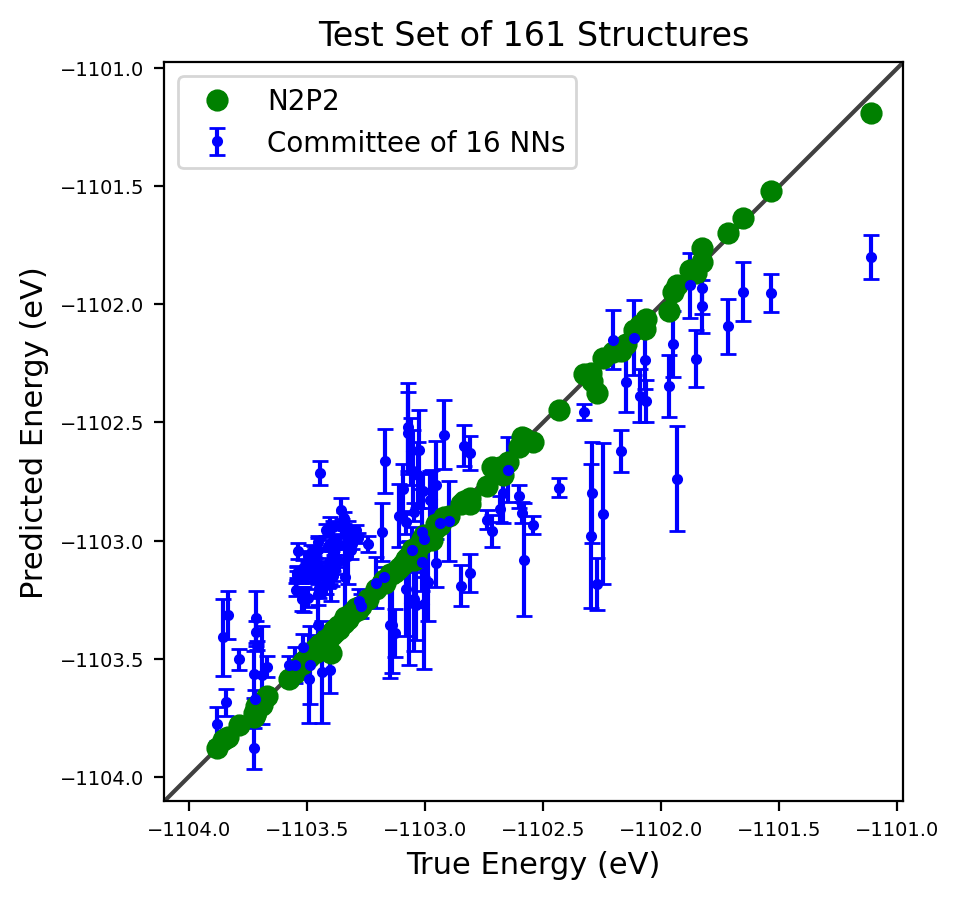

In [98]:
#Plotting Energy True vs Energy Predicted

# plt.figure(dpi = 200)
# plt.plot([-1104, -1100], [-1104, -1100])
fig, ax = plt.subplots(dpi = 200)
ax.errorbar(true_energy, mean_energy_per_frame, yerr = std_energy_per_frame, fmt= 'o', markersize = 3, capsize = 3, color = 'b', label = 'Committee of 16 NNs')
plt.plot(true_energy, n2p2_energy, 'o', markersize = 7, color = 'g', label = 'N2P2')
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

plt.xticks(fontsize = 7)
plt.yticks(fontsize = 7)
plt.xlabel('True Energy (eV)', fontsize = 11)
plt.ylabel('Predicted Energy (eV)', fontsize = 11)
plt.title('Test Set of 161 Structures', fontsize = 12)
plt.legend()
#plt.savefig(os.path.join(home,'MLR/E-true_vs_E-comm_16_&_n2p2_element-seed-9812345-22feb-0946.pdf'), dpi=200, format='pdf', bbox_inches= 'tight', pad_inches=0.1,)
plt.show()

In [97]:
#saving output into file

#savedir = {'EnergyRef': true_energy, 'n2p2': n2p2_energy, 'CommitteeMean': mean_energy_per_frame, 'CommitteeStd': std_energy_per_frame}

data = np.column_stack([true_energy, n2p2_energy, mean_energy_per_frame, std_energy_per_frame])
#datafile_path = os.path.join(home, 'committee_energy_seed-9812345-22feb-0946.txt')
#np.savetxt(datafile_path , data, fmt=['%6.10f','%6.10f', '%6.10f', '%6.10f'], delimiter='\t', header='Energref(eV)\tN2P2_energy(eV)\tCommittee_mean(eV)\tCommittee_std(eV)')
